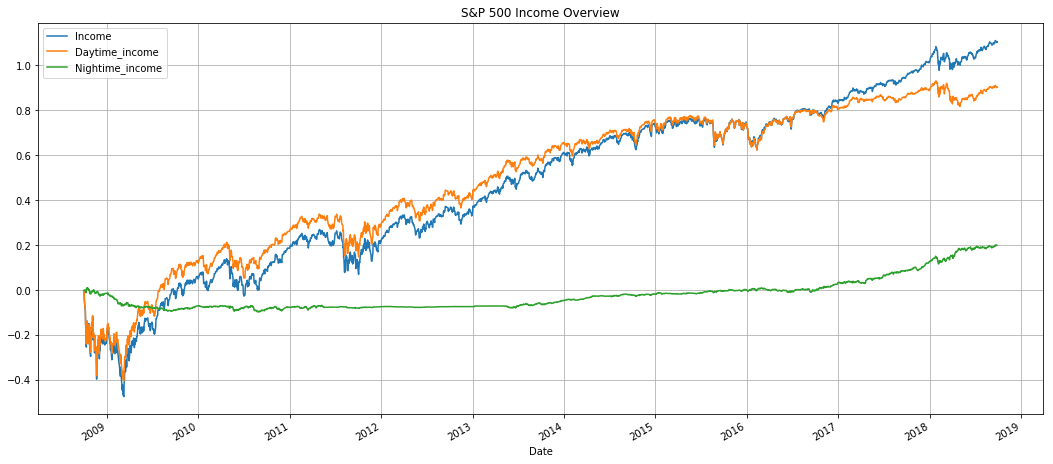

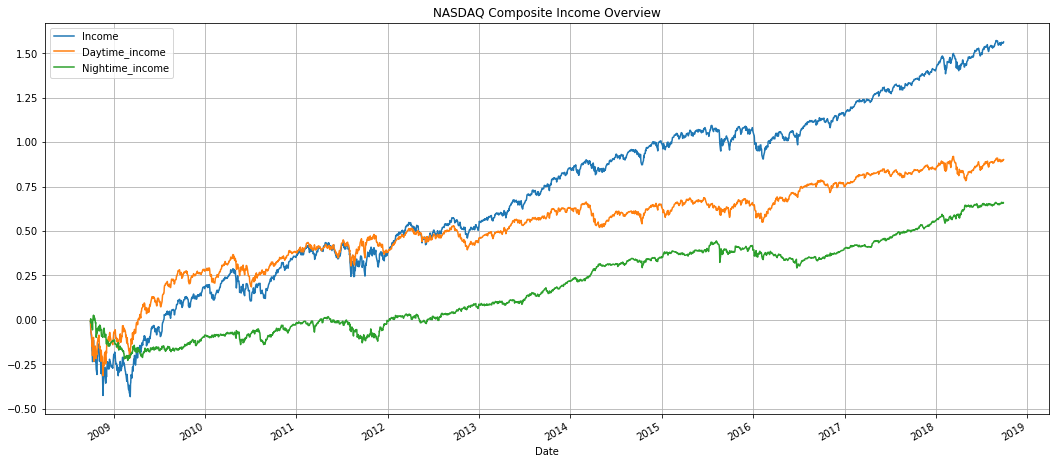

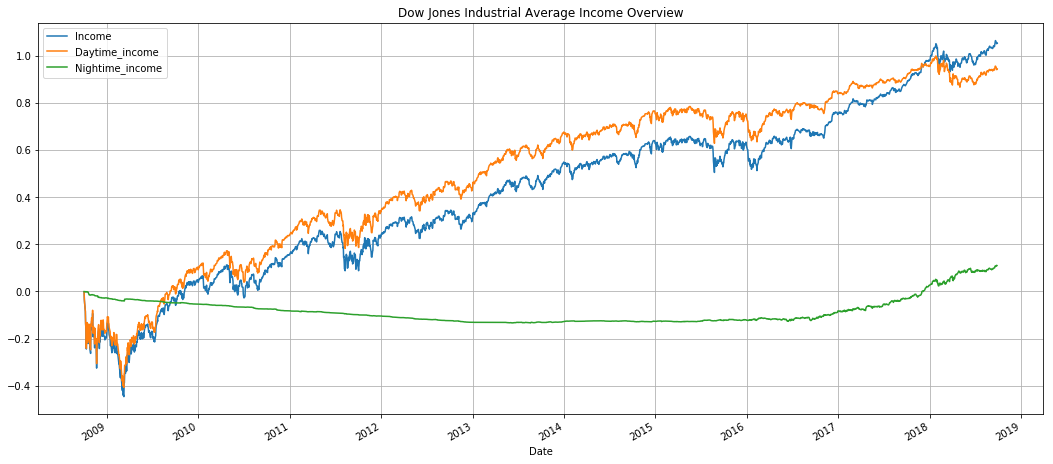

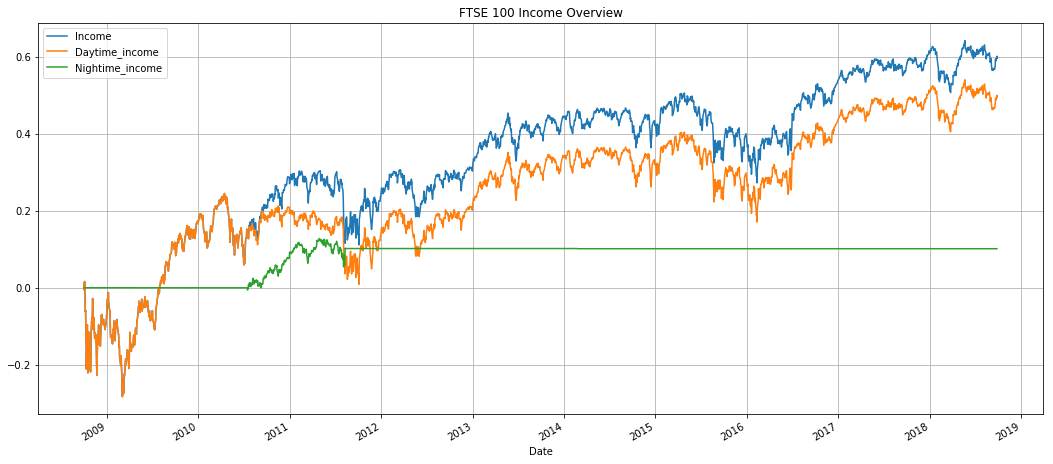

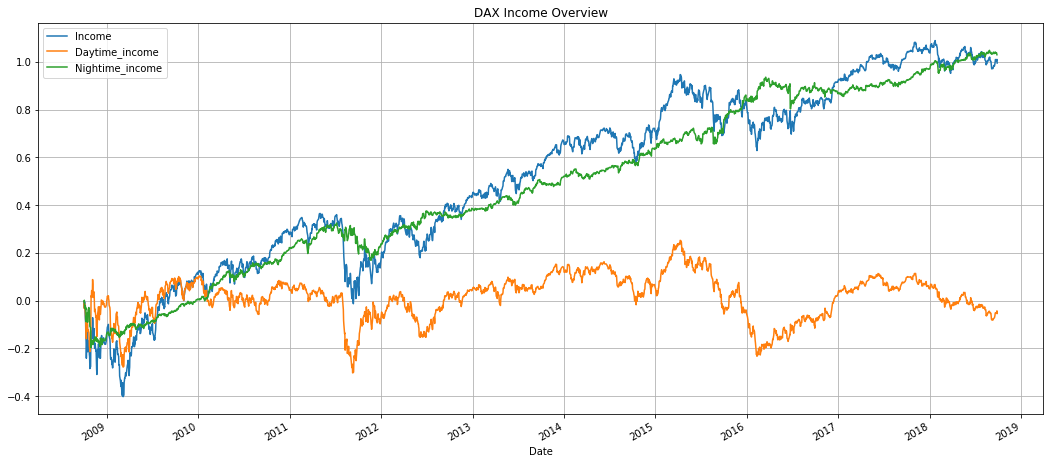

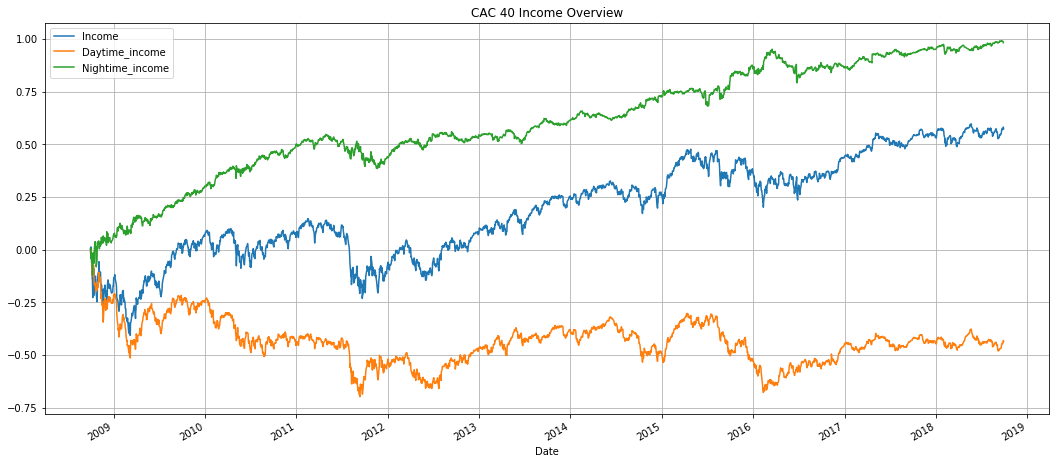

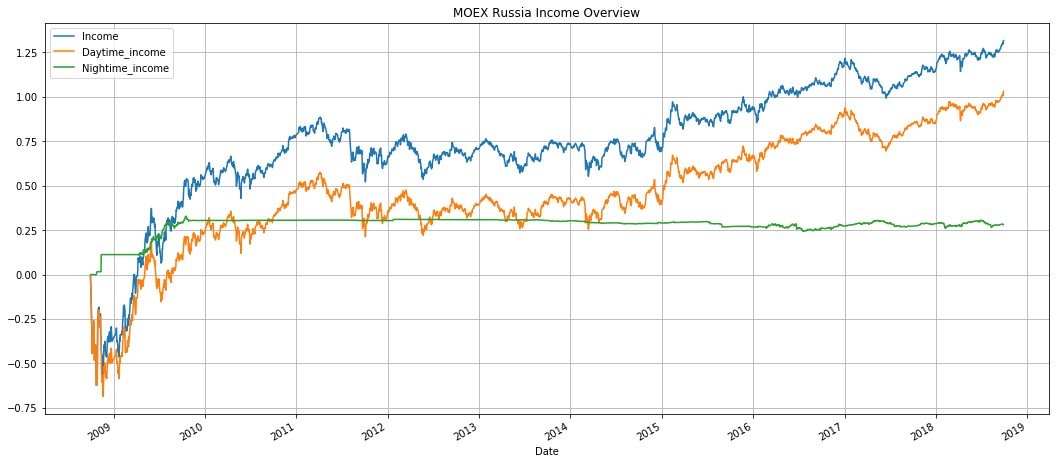

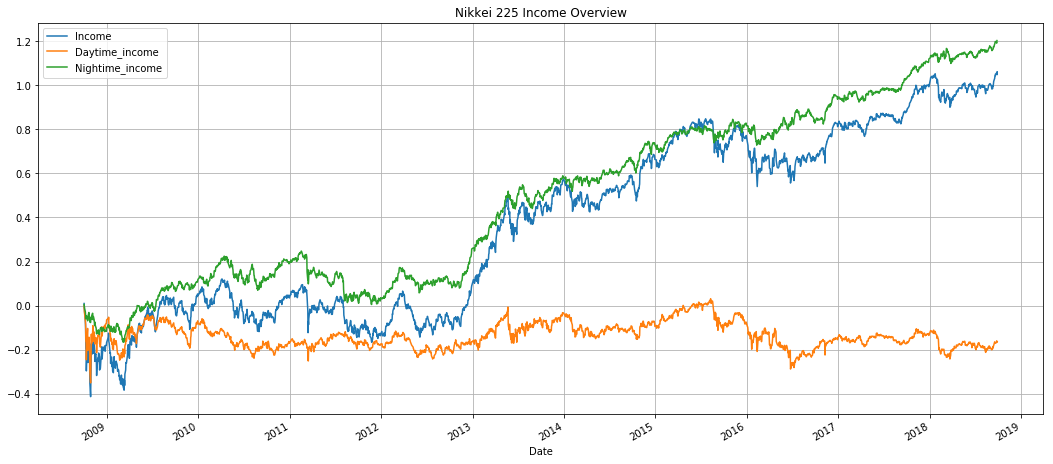

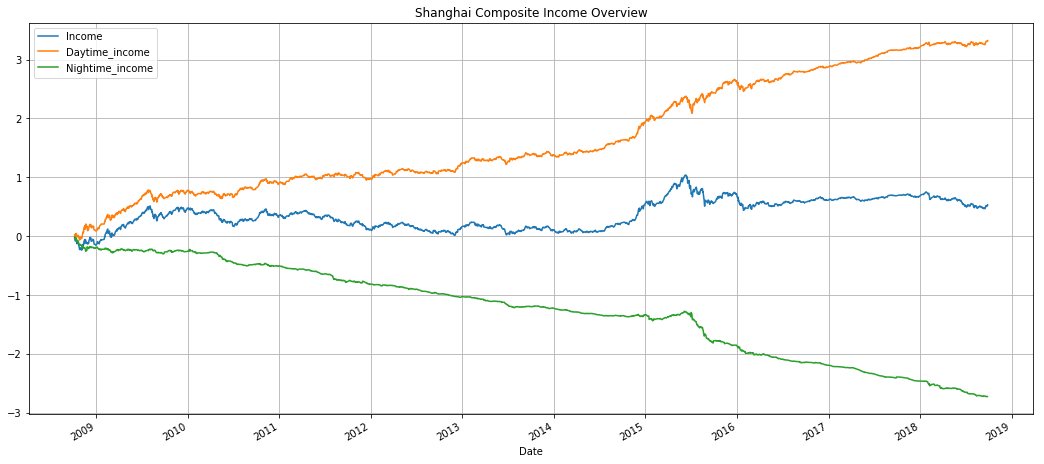

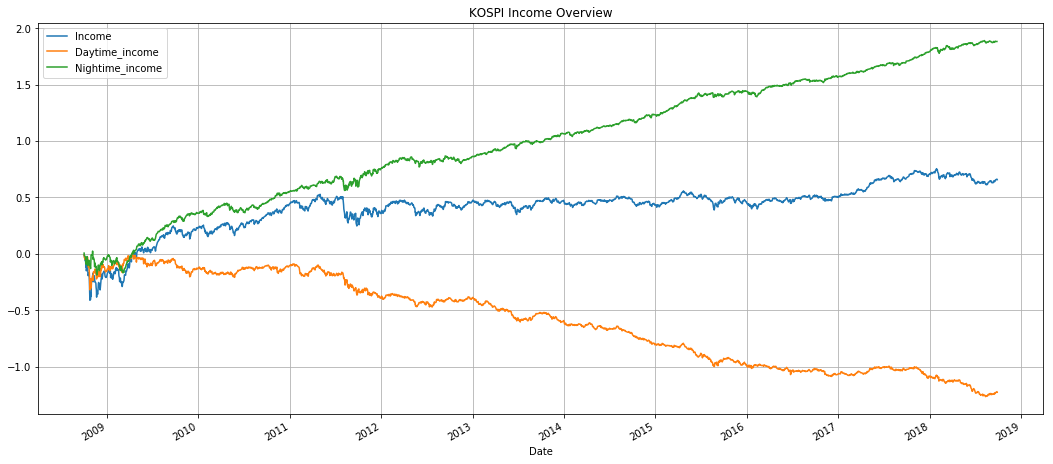

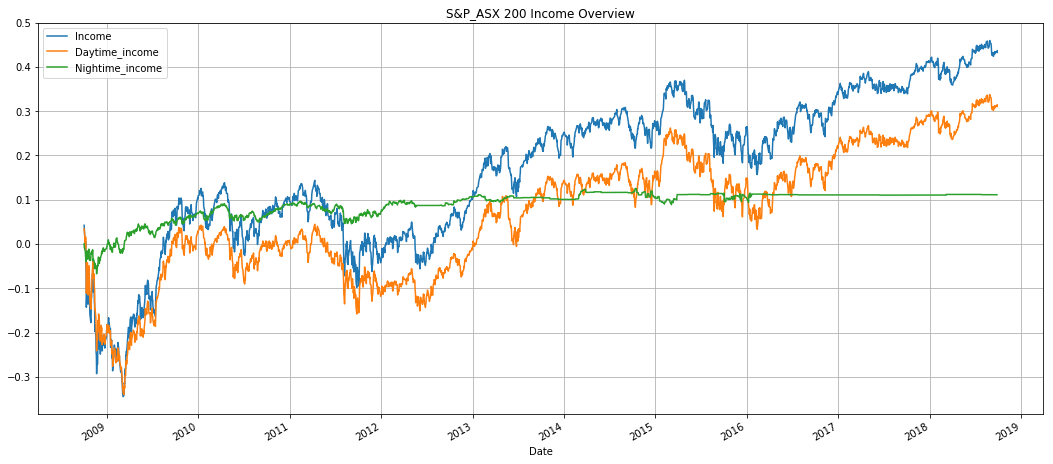

In [33]:
import csv
import numpy as np
import pandas as pd
import math
import talib
import matplotlib.pyplot as plt
import tushare as ts
#pro = ts.pro_api()

%matplotlib inline
def apply_signal(signal, change):
    income = change*signal.shift(1)
    return income.cumsum()

def scatter(name1, name2, x, y, c, rg):
    c1 = -0.001
    c2 = 0.001
    x1 = np.where(c < c1, x, np.nan).tolist()
    y1 = np.where(c < c1, y, np.nan).tolist() 
    x2 = np.where((c >= c1) & (c <= c2), x, np.nan).tolist()
    y2 = np.where((c >= c1) & (c <= c2), y, np.nan).tolist() 
    x3 = np.where(c > c2, x, np.nan).tolist()
    y3 = np.where(c > c2, y, np.nan).tolist()
    plt.plot(x1, y1, 'r.', alpha = 0.2)
    plt.plot(x3, y3, 'b.', alpha = 0.2)
    plt.plot(x2, y2, 'g.', alpha = 0.2)
    if (rg!=[0,0]):
        plt.xlim((rg[0], rg[1]))
        plt.ylim((rg[0], rg[1]))
    plt.xlabel(name1)
    plt.ylabel(name2)
    return 0
 #读取数据并格式化
#main_index_set = ['Shanghai Composite']
main_index_set = ['S&P 500', 'NASDAQ Composite', 'Dow Jones Industrial Average', 'FTSE 100', 'DAX', 'CAC 40', 'MOEX Russia', 'Nikkei 225', 'Shanghai Composite', 'KOSPI', 'S&P_ASX 200']
#main_index_set = ['sh','sz','hs300','sz50','zxb','cyb']
for main_index in main_index_set:
    data = pd.read_csv(r'd:\\data\\' + main_index + ' Historical Data.csv', thousands=',')
    data['Date'] = pd.to_datetime(data['Date'])
    #data['Price'].interpolate()
    data = data.set_index(data['Date'])
    
    #data = ts.get_hist_data(code = main_index, start = '2008-09-30', end = '2018-09-30')
    #data['Open'] = data['open']
    #data['High'] = data['high']
    #data['Low'] = data['low']
    #data['Price'] = data['close']
    
    #data = data[:500]
    data = data.sort_index(ascending=True)
    data.index=pd.to_datetime(data.index,format='%Y-%m-%d')
    #print(data)
    #计算日收益
    data['daytime_change'] = (data['Price']-data['Open'])/data['Price'].shift(1)
    data['nightime_change'] = (data['Open'].shift(-1)-data['Price'])/data['Price'].shift(1)
    data['daytime_index_change'] = data['Price']-data['Open']
    data['nightime_index_change'] = data['Open']-data['Price'].shift(1)
    data['daytime_market'] = data['Price'][0]+data['daytime_index_change'].cumsum()
    data['nightime_market'] = data['Open'][0]+data['nightime_index_change'].cumsum()
    data['change'] = data['Price']/data['Price'].shift(1) -1.0

    data['Income'] = data['change'].cumsum()
    data['Daytime_income'] = data['daytime_change'].cumsum()
    data['Nightime_income'] = data['nightime_change'].cumsum()

    data['rsi1'] = talib.RSI(np.array(data['Price']), timeperiod=6)
    data['rsi2'] = talib.RSI(np.array(data['Price']), timeperiod=24)
    data['rsi_signal'] = np.where((data['rsi2']<data['rsi1']) & (data['rsi1']>60), 1, 0)
    data['rsi_income_sum'] = apply_signal(data['rsi_signal'], data['nightime_change'])
    data['kdjk'],data['kdjd'] = talib.STOCH(np.array(data['High']),np.array(data['Low']),np.array(data['Price']), \
    fastk_period=9,slowk_period=3,slowk_matype=0,slowd_period=3,slowd_matype=0)
    data['kdj_signal'] = np.where((data['kdjk']>data['kdjd']) & (data['kdjd']>0), 1, 0)
    data['kdj_income_sum'] = apply_signal(data['kdj_signal'], data['nightime_change'])
    data['mom1'] = talib.MOM(np.array(data['change']), timeperiod=5)
    data['mom2'] = talib.MOM(np.array(data['change']), timeperiod=22)
    data['mom_signal'] = np.where(data['mom1']+data['mom2'] >0, 1, 0)
    data['mom_income_sum'] = apply_signal(data['mom_signal'], data['nightime_change'])

    #data[['Price']].plot(grid=True, figsize=(18, 4), title=main_index+' Index Overview')
    #data[['Price', 'daytime_market', 'nightime_market']].plot(grid=True, figsize=(18, 8), title=main_index+' Index Overview')
    data[['Income', 'Daytime_income', 'Nightime_income']].plot(grid=True, figsize=(18, 8), title=main_index+' Income Overview')
    #data[['Income', 'Daytime_income', 'Nightime_income', 'rsi_income_sum', 'kdj_income_sum', 'mom_income_sum']].plot(grid=True, figsize=(18, 8), title=main_index+' Income Overview')
    #data[['daytime_change', 'nightime_change']].plot(grid=True, figsize=(18, 8), title=main_index+' Change Overview')

    
    '''
    plt.figure(figsize=(9, 9),dpi=80)
    plt.subplot(1, 1, 1)
    scatter('Daytime_change', 'Nightime_change', data['daytime_change'], data['nightime_change'], data['rsi1']*0, [-0.075, 0.075])
    
    tot = 3
    col = min(3, tot)
    row = (tot-1)//col+1
    plt.figure(figsize=(col*6, row*6),dpi=80)
    plt.subplot(row, col, 1)
    scatter('RSI1', 'RSI2', data['rsi1'], data['rsi2'], data['nightime_change'], [0, 100])
    plt.plot([0,100],[0,100],'y-.')
    plt.subplot(row, col, 2)
    scatter('MOM1', 'MOM2', data['mom1'], data['mom2'], data['nightime_change'], [-0.075, 0.075])
    plt.plot([-0.1,0.1],[0.1,-0.1],'y-.')
    plt.subplot(row, col, 3)
    scatter('K', 'D', data['kdjk'], data['kdjd'], data['nightime_change'], [0, 100])
    plt.plot([0,100],[0,100],'y-.')
    plt.show()
    '''